This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Clutter detection by using space-born cloud images

In [1]:
import numpy as np

import wradlib.vis as vis
import wradlib.clutter as cl
import wradlib.georef as georef
import wradlib.ipol as ipol
import wradlib.io as io
import wradlib.util as util
import matplotlib.pyplot as plt
try:
    get_ipython().magic("matplotlib inline")
except:
    plt.ion()

### Read the radar data and count the number of tilts

In [2]:
# read the radar volume scan
filename = 'hdf5/20130429043000.rad.bewid.pvol.dbzh.scan1.hdf'
filename = util.get_wradlib_data_file(filename)
pvol = io.read_opera_hdf5(filename)

# Count the number of dataset

ntilt = 1
for i in range(100):
    try:
        pvol["dataset%d/what" % ntilt]
        ntilt += 1
    except Exception:
        ntilt -= 1
        break

### Reconstruct the radar values

In [3]:
nrays = int(pvol["dataset1/where"]["nrays"])
nbins = int(pvol["dataset1/where"]["nbins"])
val = np.empty((ntilt, nrays, nbins))
for t in range(ntilt):
    val[t, ...] = pvol["dataset%d/data1/data" % (t + 1)]
gain = float(pvol["dataset1/data1/what"]["gain"])
offset = float(pvol["dataset1/data1/what"]["offset"])
val = val * gain + offset

### Construct the corresponding radar coordinates

In [4]:
rscale = int(pvol["dataset1/where"]["rscale"])
coord = np.empty((ntilt, nrays, nbins, 3))
for t in range(ntilt):
    elangle = pvol["dataset%d/where" % (t + 1)]["elangle"]
    coord[t, ...] = georef.sweep_centroids(nrays, rscale, nbins, elangle)
# ascale = math.pi / nrays
sitecoords = (pvol["where"]["lon"], pvol["where"]["lat"],
              pvol["where"]["height"])

coord, proj_radar = georef.spherical_to_xyz(coord[..., 0],
                                           np.degrees(coord[..., 1]),
                                           coord[..., 2], sitecoords,
                                           re=6370040.,
                                           ke=4./3.)

### Construct collocated satellite data

In [5]:
filename = 'hdf5/SAFNWC_MSG3_CT___201304290415_BEL_________.h5'
filename = util.get_wradlib_data_file(filename)
sat_gdal = io.read_safnwc(filename)
val_sat = georef.read_gdal_values(sat_gdal)
coord_sat = georef.read_gdal_coordinates(sat_gdal)
proj_sat = georef.read_gdal_projection(sat_gdal)
coord_sat = georef.reproject(coord_sat, projection_source=proj_sat,
                             projection_target=proj_radar)
coord_radar = coord
interp = ipol.Nearest(coord_sat[..., 0:2].reshape(-1, 2),
                      coord_radar[..., 0:2].reshape(-1, 2))
val_sat = interp(val_sat.ravel()).reshape(val.shape)

### Estimate localisation errors

In [6]:
timelag = 9 * 60
wind = 10
error = np.absolute(timelag) * wind

### Identify clutter based on collocated cloudtype

In [7]:
clutter = cl.filter_cloudtype(val[0, ...], val_sat[0, ...],
                              scale=rscale, smoothing=error)

### Plot the results

Text(0.5,1,'Detected clutter')

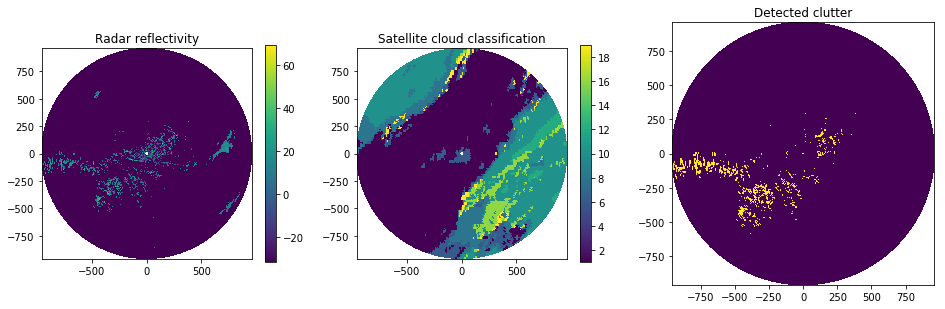

In [8]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(131)
ax, pm = vis.plot_ppi(val[0, ...], ax=ax)
plt.colorbar(pm, shrink=0.5)
plt.title('Radar reflectivity')

ax = fig.add_subplot(132)
ax, pm = vis.plot_ppi(val_sat[0, ...], ax=ax)
plt.colorbar(pm, shrink=0.5)
plt.title('Satellite cloud classification')

ax = fig.add_subplot(133)
ax, pm = vis.plot_ppi(clutter, ax=ax)
plt.title('Detected clutter')